<a href="https://colab.research.google.com/github/MuhammadIrzam447/visionCodes/blob/master/Experiment_HC_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Testing Multi-model performance for 100% images and 100% text.
# Updated Validation Dataset Class, DataLoader and Validation Loop
# Uncomment the comments in Validation Dataset, and Custom Collate_fun() to observe data loading process.

In [2]:
from google.colab import drive
import pandas as pd
import os
from PIL import Image
import torch
from torchvision import datasets, transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
import torchvision
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import UnidentifiedImageError
from sklearn.metrics import classification_report

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading Validation Dataset and Preprocessing

In [5]:
save_dir = '/content/drive/MyDrive/Colab Notebooks/Hateful-Memes/test_model'
load_path = os.path.join(save_dir, 'model.pth')

# Create an instance of the ResNet model
resnet = torchvision.models.resnet101(pretrained=False)
resnet.fc = nn.Linear(2048, 2) # Choose the number of output classses as per your model

# Load the saved model parameters
resnet.load_state_dict(torch.load(load_path))
# resnet.load_state_dict(torch.load(load_path, map_location=torch.device('cpu')))

# Set the model to evaluation mode and respective device
resnet.eval()
resnet.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
class ValidationDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, val_transform):
        self.data_dir = data_dir
        self.dataset = datasets.ImageFolder(data_dir)
        self.classes = self.dataset.classes
        self.val_transform = val_transform

        self.selected_indices = []
        for class_idx in range(len(self.classes)):
            indices = [idx for idx, (_, label) in enumerate(self.dataset.samples) if label == class_idx]
            indices_3 = [idx for idx in indices if self.dataset.samples[idx][0].endswith("_3.png")]    # _3.png are the encoded_text images
            indices_4 = [idx for idx in indices if self.dataset.samples[idx][0].endswith("_4.png")]    # _4.png are the actual images

            self.selected_indices.extend(indices_4)
            # self.selected_indices.extend(indices_3)
        print("Selected Indices:", len(self.selected_indices))
        # for idx in self.selected_indices:
          # print(self.dataset.samples[idx][0])

    def __getitem__(self, index):
        # print("Entered get_item")
        img, label = self.dataset[self.selected_indices[index]]
        filename = self.dataset.samples[self.selected_indices[index]][0]
        image_3 = None
        image_4 = None
        if filename.endswith("_4.png"):
                image_4 = img
                image_4_path = filename
                # print("image_4_path: ", str(filename))
                image_3_path = filename.replace('_4.png', '_3.png')
                # print("image_3_path: ", str(image_3_path))
                image_3 = self._load_image(image_3_path)
        else:
                image_3 = img
                image_3_path = filename
                # print("image_3_path: ", str(filename))
                image_4_path = filename.replace('_3.png', '_4.png')
                # print("image_4_path: ", str(image_4_path))
                image_4 = self._load_image(image_4_path)

        # print("Exit get_item")
        return image_3, image_4, label, image_3_path, image_4_path

    def _load_image(self, path):
        image = Image.open(path)
        return image

    def __len__(self):
        return len(self.selected_indices)

In [8]:
valPath = "/content/drive/MyDrive/Colab Notebooks/Hateful-Memes/Joint_mulitmodal/test"
val_dataset = ValidationDataset(valPath,val_transform)

Selected Indices: 2000


In [9]:
def custom_collate(batch):
    to_tensor = transforms.ToTensor()
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    images_3 = [val_transform(item[0]) for item in batch]
    images_4 = [val_transform(item[1]) for item in batch]
    labels = [torch.tensor(item[2]) for item in batch]

    images_3 = torch.stack(images_3)
    images_4 = torch.stack(images_4)

    # Print the filenames in each list
    # print("Filenames in images_3 list:")
    # for item in batch:
    #     if item[0] is not None:
    #         print(item[3])

    # print("Filenames in images_4 list:")
    # for item in batch:
    #     if item[1] is not None:
    #         print(item[4])

    return images_3, images_4, labels


In [10]:
batch_size = 12
validation_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate)

In [11]:
print("Number of samples:", len(val_dataset))
print("Number of classes:", len(val_dataset.classes))

Number of samples: 2000
Number of classes: 2


In [12]:
num_batches = len(validation_data_loader)
print("Number of batches:", num_batches)

Number of batches: 167


# Validation

In [13]:
resnet.eval()

# Initialize lists to store the average probabilities and true labels
predicted_labels = []
true_labels = []

# Iterate over the dataloader in your testing loop
for images_3, images_4, labels in validation_data_loader:

    images_3 = images_3.to(device)
    # images_4 = images_4.to(device)

    logits_3 = resnet(images_3)
    # logits_4 = resnet(images_4)
    logits_4 = torch.zeros_like(logits_3)

    probabilities_3 = torch.softmax(logits_3, dim=1)
    probabilities_4 = torch.softmax(logits_4, dim=1)

    avg_probabilities_batch = (probabilities_3 + probabilities_4) / 2

    predicted_labels.extend(avg_probabilities_batch.cpu().tolist())

    true_labels.extend(labels)

In [14]:
predicted_classes = torch.argmax(torch.tensor(predicted_labels), dim=1)
actual_labels = torch.tensor(true_labels)

In [15]:
accuracy = accuracy_score(actual_labels, predicted_classes)
precision = precision_score(actual_labels, predicted_classes, average='weighted')
recall = recall_score(actual_labels, predicted_classes, average='weighted')
f1 = f1_score(actual_labels, predicted_classes, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.6215
Precision: 0.5733423470788119
Recall: 0.6215
F1-score: 0.5285992155994965


In [16]:
print(classification_report(actual_labels, predicted_classes))

              precision    recall  f1-score   support

           0       0.63      0.94      0.76      1250
           1       0.47      0.09      0.15       750

    accuracy                           0.62      2000
   macro avg       0.55      0.51      0.45      2000
weighted avg       0.57      0.62      0.53      2000



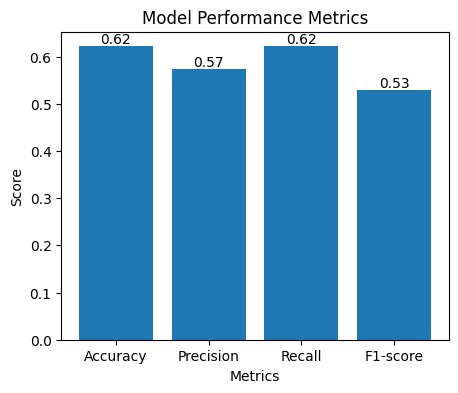

In [17]:
labels = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [accuracy, precision, recall, f1]

x = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(5, 4))
bars = ax.bar(x, values)

# labels, title, and legend
ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Model Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(labels)

# scores on top of each bar
for i, bar in enumerate(bars):
    score = values[i]
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{score:.2f}', ha='center', va='bottom')

plt.show()

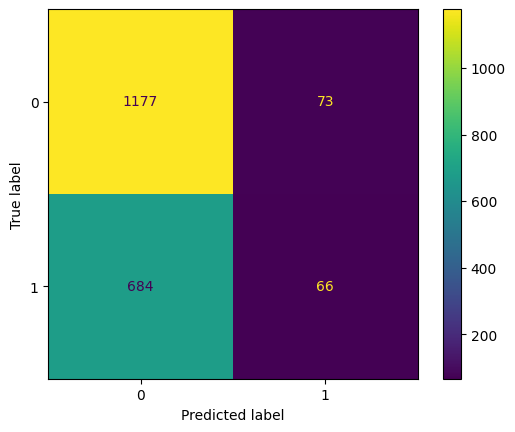

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(actual_labels, predicted_classes)
ConfusionMatrixDisplay(cm).plot()

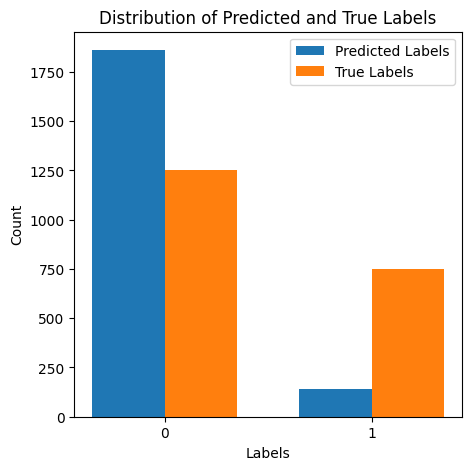

In [19]:
# Count the occurrences of each label in predicted and true labels
predicted_counts = np.bincount(predicted_classes)
true_counts = np.bincount(actual_labels)

# Get the unique labels
labels = np.unique(np.concatenate((predicted_classes, actual_labels)))

# Set the x-axis range
x = np.arange(len(labels))

# Set the width of the bars
width = 0.35

# Plot the predicted and true label counts
fig, ax = plt.subplots(figsize=(5,5))
ax.bar(x - width/2, predicted_counts, width, label='Predicted Labels')
ax.bar(x + width/2, true_counts, width, label='True Labels')

# Add labels, title, and legend
ax.set_xlabel('Labels')
ax.set_ylabel('Count')
ax.set_title('Distribution of Predicted and True Labels')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()